In [1]:
import pickle
import networkx as nx
import matplotlib.pyplot as plt
import torch

In [91]:
filepath = r"D:\Uni\BA\Development\GA\GA_logs\final\SIS_ba10_1k_eval_dynamic_200ep\2021-03-08T06_25_33.803093"
gt_mat_path = r"D:\Uni\BA\Development\data\final\edges_ba10.pickle"

In [92]:
with open(gt_mat_path,'rb') as f:
    gt_mat = pickle.load(f)

with open(filepath+'/lineage.txt') as f:
    content = f.readlines()
# you may also want to remove whitespace characters like `\n` at the end of each line
content = [x.strip() for x in content]

generations = content[1::4]
#print(generations)
gen_split = [[ind.replace(".","") for ind in gen.split('. ')] for gen in generations]
#print(gen_split)
gt_hash = '27a06185e85d7864' if False else 'c7cc2e5aaa95c0cd' #gen_split[-1][0]
print(gt_hash)

parents = content[3::4]
par_split = [[int(num.replace(".","")) for num in gen.split('. ')] for gen in parents]

cut_to_gen = 15
gen_split=gen_split[:cut_to_gen]
par_split=par_split[:cut_to_gen-1]
print(len(gen_split))

with open(filepath+'/all_populations.pickle','rb') as f:
    all_populations = pickle.load(f)
all_populations = all_populations[:cut_to_gen]
print(len(all_populations))

c7cc2e5aaa95c0cd
15
15


In [6]:
#with open(filepath+'/losses.pickle') as f:
#    losses = pickle.load(f)
#print(losses)

In [5]:
def colorPath(G, key):
    in_eds = G.in_edges(key,keys=True)
    for u,v,k in in_eds:
        G.add_edge(u,v,key=k, color='g')
    for pred in G.predecessors(key):
        colorPath(G,pred)

In [6]:
def calc_dist(mat1, mat2):
    N = mat1.size()[0]
    num = 0
    for i in range(N):
        for j in range(i+1,N):
            if not torch.eq(mat1[i,j], mat2[i,j]):
                num += 1
    return num

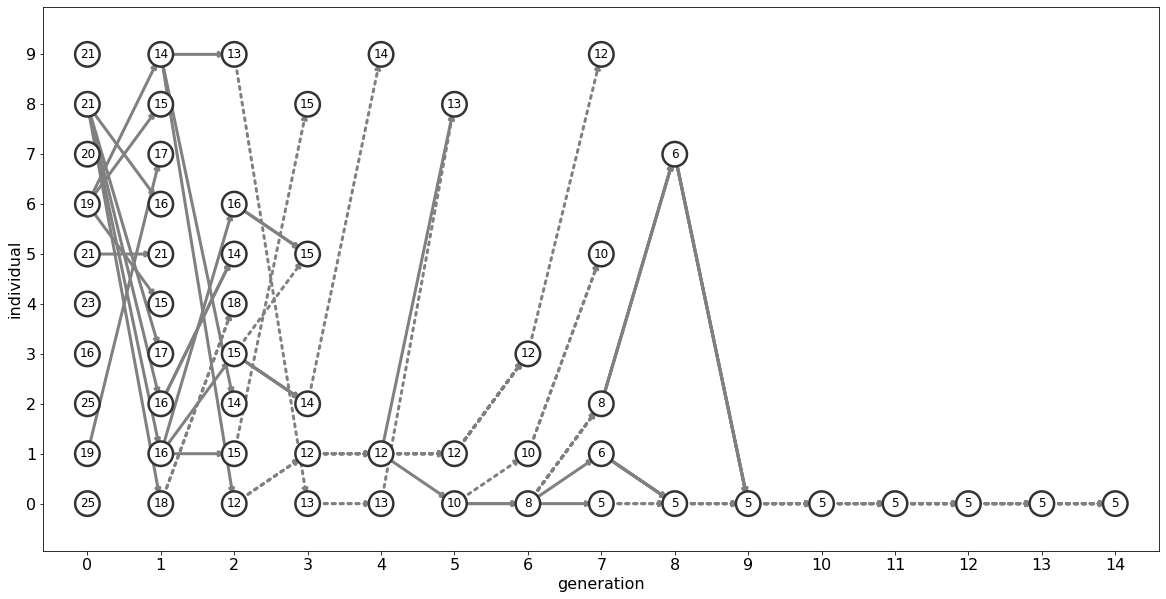

In [93]:
G = nx.MultiDiGraph()
pos_dict = {}

# add nodes
for gen_num, gen in enumerate(gen_split):
    for i, string in enumerate(gen):
        dist = calc_dist(all_populations[gen_num][i], gt_mat)
        G.add_node((gen_num, i), hash_string=string, dist=dist)
        pos_dict[(gen_num, i)] = (gen_num,i)
        
# add edges
hash_strings = nx.get_node_attributes(G, 'hash_string')
for parents_num, parents in enumerate(par_split):
    for i, par in enumerate(parents):
        style = 'dotted' if hash_strings[(parents_num, par)] == hash_strings[(parents_num+1, i)] else 'solid'
        G.add_edge((parents_num, par), (parents_num+1, i), style=style)
        
# merge nodes
for gen in range(len(gen_split)):   
    for i in range(len(gen_split[0])):
        for j in range(i+1, len(gen_split[0])):
            if (gen,i) in G and (gen,j) in G:
                if G.nodes[(gen,i)]['hash_string'] == G.nodes[(gen,j)]['hash_string']:
                    G = nx.contracted_nodes(G, (gen,i), (gen,j))
                    
# color gt and path to gt
color_map = ['g' if hs == gt_hash else 'w' for hs in nx.get_node_attributes(G, 'hash_string').values()]    
nx.set_edge_attributes(G,values='.5',name='color')
gt_list = [key for key,hs in nx.get_node_attributes(G, 'hash_string').items() if hs==gt_hash]
if len(gt_list)>0:
    gt_key = gt_list[-1]
    colorPath(G,gt_key)
                
fontsize = '16'
import matplotlib.pylab as pylab
params = {'legend.fontsize': fontsize,
          'figure.figsize': (20, 10),
          'axes.labelsize': fontsize,
          'axes.titlesize': fontsize,
          'xtick.labelsize': fontsize,
          'ytick.labelsize': fontsize}
pylab.rcParams.update(params)
fig, ax = plt.subplots()

#print(color_map)
#node_edgecolors = nx.get_node_attributes(G, 'color')
nx.draw_networkx_nodes(G, pos_dict, node_size=600, node_color=color_map, linewidths=2.5, edgecolors='.2', ax=ax)
nx.draw_networkx_labels(G,pos_dict, labels=nx.get_node_attributes(G,'dist'))

solid_edges = [key for key, style in nx.get_edge_attributes(G, 'style').items() if style=='solid']
dotted_edges = [key for key, style in nx.get_edge_attributes(G, 'style').items() if style=='dotted']
solid_edge_colors = [nx.get_edge_attributes(G, 'color')[x] for x in solid_edges]
dotted_edge_colors = [nx.get_edge_attributes(G, 'color')[x] for x in dotted_edges]
nx.draw_networkx_edges(G, pos_dict, solid_edges, edge_color=solid_edge_colors, width=3.0, alpha=1, style='solid', ax=ax)
nx.draw_networkx_edges(G, pos_dict, dotted_edges, edge_color=dotted_edge_colors, width=3.0, alpha=1, style='dotted', ax=ax)

ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
ax.set_ylabel('individual')
ax.set_xlabel('generation')
plt.xticks(range(0, len(gen_split)))
plt.yticks(range(0, len(gen_split[0])))
plt.xlim([-0.6, len(gen_split)-1+0.6])
plt.show()

In [94]:
save_path = r"D:\Uni\BA\0_Bachelorarbeit\tex\Figures\GA_viz\SIS_ba10_1k_eval\803093.png"
fig.savefig(save_path, dpi=200, bbox_inches='tight', pad_inches=0.01)
print('done')

done
